# Neurális Hálózatok

A neurális hálózatok építőelemei nagyon emlékeztetnek a logisztikus regresszióra. A logisztikus regresszió úgy működött, hogy kiszámolta a feature-ök súlyozott összegét, és az eredményt áttolta egy nemlineáris függvényen (a szigmoid függvényen). Láttuk, hogy alapesetben lineáris decision boundary-t (osztályokat elválasztó határvonalat) kapunk, de megfelelő új feature-ök hozzáadásával ezen a korlátozáson túl tudtunk lépni. A gond az, hogy nehéz kitalálni, hogy feature-ök milyen kombinációja vezet a legjobb eredményre. A neurális hálók tulajdonképpen ennek a problémának a megoldását automatizálják.

A logisztikus regresszió minden bemenő feature-éhez készítünk egy újabb logisztikus regressziót, amely az eredeti feature-öket kombinálva, egy nemlinearitáson (szigmoid függvényen) keresztül, egy származtatott feature-t képez. Ennek a logisztikus regressziónak a paramétereit (súlyok, eltolás) szintén bevonjuk az optimalizálásba, és az optimalizálás során kialakul (a modell "megtanulja"), hogy a feature-ök milyen kombinációja vezet a legjobb eredményre.

És már meg is érkeztünk a neurális hálózatokhoz. Minden egyes neuron ugyanazt csinálja: súlyozva összeadja a bemeneteit, hozzáad egy eltolást, és az eredményen végrehajt egy nemlineáris függvényt, ez lesz a kimenete. A kimenetre aztán újabb neuronokat lehet kapcsolni, így egy hálózathoz jutunk. A nemlinearitást aktivációnak, vagy aktivációs függvénynek hívják.

![](https://www.learnopencv.com/wp-content/uploads/2017/10/neuron-diagram.jpg)

Az utóbbi évtizedekben rájöttek, hogy sokkal jobb a neurális hálózatok teljesítménye, ha szigmoid függvény helyett "rectified linear unit" a nemlinearitás, hiszen ennek a függvénynek (legalábbis a pozitív tartományban) határozott grádiense van.

![](https://www.learnopencv.com/wp-content/uploads/2017/10/relu-activation-function-1.png)

Az egyes neuronokból egy réteges szerkezetű hálózat építhető, melyben az egyik réteg feladata a következő réteg számára a feature-ök összeállítása. A bemenetre az eredeti feature-öket adjuk, a kimeneten pedig leolvassuk a célváltozó becslését. Regressziós probléma esetén az utolsó neuronra lineáris aktivációt teszünk, klasszifikáció esetén pedig szigmoidot.

![](https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png)

A súlyok és az eltolások optimalizálása történhet a már megismert sztochasztikus gradient descent algoritmussal. Csakhogy ahhoz tudni kellene a loss függvény grádienseit minden egyes súly szerint, aminek a kiszámítása egy összetettebb hálózat esetén elég nagy kihívás. Erre, vagyis a grádiensek szisztematikus, hatékony kiszámítására szolgál a back-propagation algoritmus, melyet itt nem részletezünk.

A neurális hálózatokat egy példán keresztül ismerjük meg. Az adatsor egy olasz mobil hálózat adatait tartalmazza. A hálózat négyzet alakű zónákra van osztva ("squareid" azonosítja), és minden zónára minden egyes órára meg van adva, hogy melyik körzetszámmal hány bemenő és kimenő sms-t illetve hívást bonyolított le, és mennyi internet adatot forgalmazott.

A terjedelmes adatsorból első lépésként készítünk egy kompaktabb változatot (körzetszámra aggregálva), és kimentjük.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [19]:
# betöltünk egy új adatsort, távközlési adatokból áll
# csinálunk vele ezt-azt, aggregálunk körzetszám szerint, összetesszük mindet egy táblába, és kimentjük csv-be
for i in range(1,31):
    tcom = pd.read_csv("/webspn/oktatas/2018a-ml/data/trentotelco/sms-call-internet-tn-2013-11-{:02}.txt".format(i), delimiter="\t", header=None, names=["squareid", "timestamp", "countrycode", "smsin", "smsout", "callin", "callout", "internet"])        
    tcom = tcom.groupby(["squareid","timestamp"]).sum()
    tcom.reset_index(inplace=True)
    tcom["hour"] = tcom["timestamp"]//3600000
    tcom = tcom.groupby(["squareid", "hour"]).agg({"smsin":"sum", "smsout":"sum", "callin":"sum", "callout":"sum", "internet":"sum"})
    tcom.reset_index(inplace=True)
    if i==1:
        dta = tcom
    else:
        dta = dta.append(tcom)
dta.to_csv("data/telco.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


Először betöltjük az adatokat, és kidobjuk azokat a zónákat, melyek nem teljes idősort tartalmaznak (pár óra hiányzik belőlük). A kényelem kedvéért most nem szeretnénk velük foglalkozni. Látni fogjuk, hogy alig vesztettünk valamit.

In [2]:
dta = pd.read_csv("data/telco.csv", index_col=0)
# nézzünk egy áttekintő képet az adatokról:
display(dta[1:10])
# hány zóna (mező) van?
print("mezők száma: ", len(np.unique(dta["squareid"])))
# válasszuk ki azokat, melyek teljes idősorokat tartalmaznak
idcnt = dta.groupby("squareid")["hour"].count()
fullts = idcnt.index[idcnt==720]
print("teljes idősorral rendelkezik: ", len(fullts))
dta = dta[dta["squareid"].isin(fullts)]

,squareid,hour,smsin,smsout,callin,callout,internet
1,38,384240,1.097136,2.739491,0.033146,0.019763,53.550552
2,38,384241,1.001066,2.334906,0.414200,0.238357,56.370072
3,38,384242,0.330291,1.296179,0.108073,0.000000,54.443087
4,38,384243,0.595967,0.820119,0.104597,0.033146,50.946916
5,38,384244,0.808592,0.200928,0.093115,0.123046,52.458089
6,38,384245,1.391219,2.491218,0.862393,0.332312,63.130320
7,38,384246,2.289374,0.971929,0.663619,0.850765,67.252935
8,38,384247,9.918490,4.923641,1.183932,2.852245,103.966948
9,38,384248,11.146825,3.827831,3.539031,4.013754,140.714442


mezők száma:  6259
teljes idősorral rendelkezik:  6128


Vessünk egy pillantást az egyik zóna idősoraira. Jól kivehető a napi és - különösek a hívás adatokból - a heti szezonalitás is.

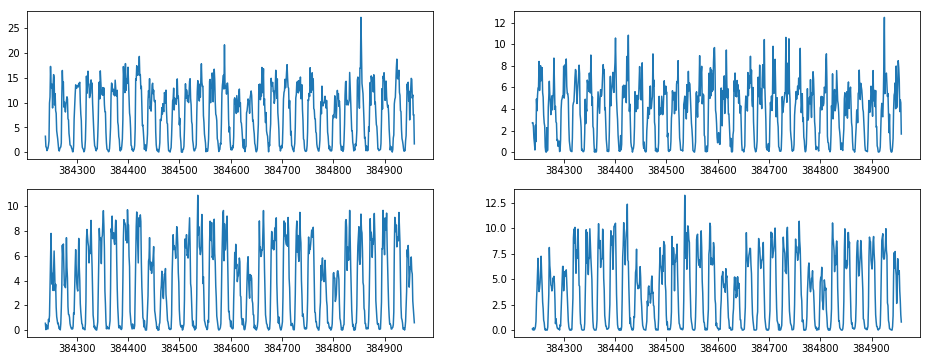

In [3]:
# nézzük meg az egyik cella idősorait
subdta = dta.loc[dta["squareid"]==38]
f, plots = plt.subplots(2, 2)
plots[0][0].plot(subdta["hour"], subdta["smsin"])
plots[0][1].plot(subdta["hour"], subdta["smsout"])
plots[1][0].plot(subdta["hour"], subdta["callin"])
plots[1][1].plot(subdta["hour"], subdta["callout"])
f.set_size_inches(16,6)

## A tanító, validációs és teszt halmaz fogalma

A neurális hálók, különösen, ha nagyon mélyek, és sok neuront tartalmaznak, könnyedén túltanulják a tanító halmazt, azaz alacsony loss értéket kapunk a tanulóhalmazra, viszont az új megfigyelések esetén rossz lesz a predikció.

Ennek kezelésére a bevett módszer, hogy a megfigyeléseinket tanuló, validációs és teszt halmazokra bontjuk. A tanulóhalmazba szokták tenni a megfigyelések 70-80%-át, ezzel történik a modell tanítása. 

A validációs halmaz és a teszt halmaz a fennmaradó megfigyelésekből áll elő, 50-50% megosztásban. A validációs halmaz célja, hogy a modellünket ki tudjuk értékelni olyan adatokon is, melyeket a modell tanítás közben nem látott. A validációs eredményeket fel tudjuk használni a modell hiperparamétereinek beállítására. Pl. készíthetünk egy modellt lineáris regresszióval, egy másikat egyrétegű, 10 neuronból álló neurális hálóval, egy harmadikat pedig egy nagyon mély, több száz neuront tartalmazó neurális hálóval. Mindegyiket betanítjuk a tanulóhalmazzal, és a három modell közül az alapján választunk, hogy a validációs halmazon hogyan teljesítenek. Lehet póbálgatni különböző aktivációs függvényeket, különböző számú rétegeket, különböző számú neuronokat, a validációs halmaz teszi lehetővé, hogy ezeket a próbálkozásokat objektív módon össze tudjuk vetni egymással.

A teszt halmaz célja pedig az, hogy végleges modellt, az optimalizált hiperparaméterekkel ki tudjuk próbálni olyan adatokon, melyeket még soha semmilyen formában nem használtunk, még a modellek közötti válogatás és a hiperparaméterek állítása során sem.

Elsőként tehát random zónákat választunk ki a tanuló, a validációs és a teszt halmazba.

In [4]:
# random zónák kiválasztása
ix = np.random.choice(dta["squareid"].unique(), size=1000)
# 80% tanuló halmaz
trix = ix[0:800]
# 10% validációs halmaz
valix = ix[800:900]
# 10% teszt halmaz
tstix = ix[900:1000]
trset = dta[dta["squareid"].isin(trix)]
valset = dta[dta["squareid"].isin(valix)]
tstset = dta[dta["squareid"].isin(tstix)]

Ebben a konkrét példában a korábbi órák értékei alapján szeretnénk becsülni a következőt. Ehhez át kell alakítani a tanulóhalmazt úgy, hogy az a felhasznált feature-öket időben eltolva is tartalmazza.

In [65]:
# a tqdm egy jópofa progress csík az algoritmus futási idejének nyomon követésére
from tqdm import tqdm_notebook
# dset: a dataframe, cols: a feature-ök amiket eltolva hozzá szeretnénk ragasztani, lag: az eltolások száma (mennyivel megyünk vissza az időben)
def add_shifted_features(dset, cols, lag):
    resdf = None    
    sqid = np.unique(dset["squareid"]) # összeszedjük a különböző zónákat
    for sid in tqdm_notebook(sqid): # minden zónán végigmegyünk, és eltoltan ragasztunk. Itt frissül a progress csík is
        subst = dset[dset["squareid"]==sid] # kiválasztjuk az adott zónát
        tolag = subst[cols] # kiválasztjuk a kért oszlopokat
        for i in range(1, lag+1):
            tolag.columns = [x+"."+str(i) for x in cols] # az oszlopnevek beállítása
            subst = pd.concat([subst, tolag.shift(i)], axis=1) # hozzáadjuk az eltolt oszlopokat (oszlop ragasztás)
        # mehet hozzá a többi, már elkészült zónához (soronkénti ragasztás)
        if resdf is None:
            resdf = subst
        else:
            resdf = resdf.append(subst)
    # az NA értékekeket tartalmazó sorok eldobása
    resdf = resdf.dropna()
    # az összekuszálódott sor indexet reset-elése
    resdf.reset_index(drop=True, inplace=True)
    return resdf

In [204]:
# mehet a feature-ök hozzáadása!
features = ["callin", "callout", "internet"]
lags = 12
trprep = add_shifted_features(trset, features, lags)
valprep = add_shifted_features(valset, features, lags)
tstprep = add_shifted_features(tstset, features, lags)

Összeállítjuk a tanuláshoz használt feature-öket, és a célváltozót

In [205]:
trfeatures = []
for i in range(lags):
    trfeatures = trfeatures + [x+"."+str(i+1) for x in features]
trtarget = "callin"

## A neurális háló tanítása

A Keras egy nagyon egyszerű keretet ad a kezünkbe, melynek segítségével pillanatok alatt összedobhatunk egy neurális hálót. Mi most csak a legegyszerűbb neurális hálókkal, a *sűrű* (dense) hálókkal fogunk próbálkozni, bár fontos megjegyezni, hogy pont az idősorok előrejelzésére ez nem pont az ideális választás.

In [137]:
import keras, keras.layers as L

Csinálunk egy három rétegű topológiát, az első rétegben 32, a másodikban 64, az utolsóban pedig 1 neuronnal. Az utolsónak ráadásul lineáris a kimenete, ez lesz a modell előrejelzése. Ezek véletlenszerű paraméterek, valószínűleg a topológia hangolásával jelentősen javítható lenne a predikciós pontosság.

In [235]:
predmdl = keras.models.Sequential()
predmdl.add(L.Dense(units=72, input_dim=len(trfeatures), activation="relu"))
predmdl.add(L.Dense(units=72, activation="relu"))
#predmdl.add(L.Dense(units=72, activation="relu"))
predmdl.add(L.Dense(units=1, activation="linear"))

A modell súlyait az "adam" optimalizálóval állítjuk, ami a sztochasztikus gradient descent egyik legfejlettebb variánsa, annál sokkal gyorsabban konvergál. A célfüggvény a megfigyelt és az előrejelzett célváltozó átlagos négyzetes hibája (MSE).

In [236]:
predmdl.compile(optimizer="adam", loss='mse')

In [237]:
# kiírjuk a modell paramétereit
predmdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 72)                2664      
_________________________________________________________________
dense_57 (Dense)             (None, 72)                5256      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 73        
Total params: 7,993
Trainable params: 7,993
Non-trainable params: 0
_________________________________________________________________


Jöhet a tanítás! Oda kell neki adni a tanulóhalmazt és a célváltozó megfigyelt értékeit, és az epoch-ok számát (ennyiszer tolja végig a tanulóhalmazt a hálón tanítás közben). A validációs halmazt is odaadjuk neki, így minden kör után kiírja, hogy mogy teljesít a modell a validációs adatokon, melyeket egyébként nem használ fel a tanítás során.

In [238]:
history = predmdl.fit(x=trprep[trfeatures].as_matrix(), y=trprep[trtarget], epochs=20, 
            validation_data=[valprep[trfeatures].as_matrix(), valprep[trtarget]], batch_size=512)

Train on 526752 samples, validate on 70800 samples
Epoch 1/20
526752/526752 [==============================] - 3s - loss: 297.2121 - val_loss: 38.8356
Epoch 2/20
526752/526752 [==============================] - 3s - loss: 52.8818 - val_loss: 24.4113
Epoch 3/20
526752/526752 [==============================] - 3s - loss: 43.1691 - val_loss: 24.4267
Epoch 4/20
526752/526752 [==============================] - 3s - loss: 27.9941 - val_loss: 20.9496
Epoch 5/20
526752/526752 [==============================] - 3s - loss: 27.8677 - val_loss: 18.0319
Epoch 6/20
526752/526752 [==============================] - 3s - loss: 27.5733 - val_loss: 13.7176
Epoch 7/20
526752/526752 [==============================] - 3s - loss: 22.0819 - val_loss: 16.0303
Epoch 8/20
526752/526752 [==============================] - 3s - loss: 20.3185 - val_loss: 13.8255
Epoch 9/20
526752/526752 [==============================] - 3s - loss: 18.7086 - val_loss: 11.6779
Epoch 10/20
526752/526752 [==============================

Errenőrizzük a modellt, a teszt zónák közül az elsőn. Kivágjuk a vonatkozó adatokat, lefuttatjuk a predikciót, és kirajzoljuk azt, a valósággal együtt.

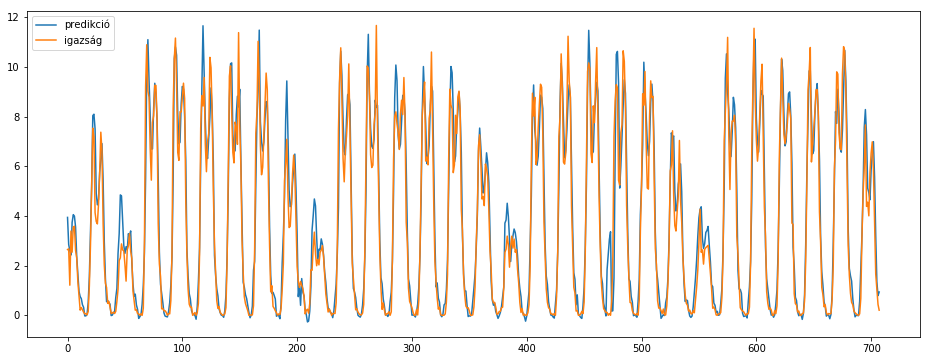

In [242]:
sqid = tstix[20]
subdta = tstprep[tstprep["squareid"]==sqid]
prd = predmdl.predict(subdta[trfeatures].as_matrix())
truth = subdta[trtarget].as_matrix()
f = plt.figure()
plt.plot(prd, label="predikció")
plt.plot(truth, label="igazság")
plt.legend()
f.set_size_inches(16,6)

A Keras segítségével nem csak neurális háló modelleket építhetünk, hanem lineáris regressziót is, hiszen az a neurális háló speciális esete. Ebben az esetben egyetlen rétegünk lesz, egyetlen neuronnal, lineáris aktivációval.

In [246]:
linearmdl = keras.models.Sequential()
linearmdl.add(L.Dense(units=1, input_dim=len(trfeatures), activation="linear"))
linearmdl.compile(optimizer="adam", loss='mse')
history = linearmdl.fit(x=trprep[trfeatures].as_matrix(), y=trprep[trtarget], epochs=40, 
            validation_data=[valprep[trfeatures].as_matrix(), valprep[trtarget]], batch_size=512)

Train on 526752 samples, validate on 70800 samples
Epoch 1/40
526752/526752 [==============================] - 2s - loss: 830.5091 - val_loss: 692.9894
Epoch 2/40
526752/526752 [==============================] - 2s - loss: 582.7381 - val_loss: 539.3053
Epoch 3/40
526752/526752 [==============================] - 2s - loss: 468.7385 - val_loss: 427.2700
Epoch 4/40
526752/526752 [==============================] - 2s - loss: 368.2325 - val_loss: 359.3404
Epoch 5/40
526752/526752 [==============================] - 2s - loss: 290.8924 - val_loss: 286.2960
Epoch 6/40
526752/526752 [==============================] - 2s - loss: 232.7650 - val_loss: 222.4986
Epoch 7/40
526752/526752 [==============================] - 2s - loss: 191.2142 - val_loss: 172.0351
Epoch 8/40
526752/526752 [==============================] - 2s - loss: 145.6101 - val_loss: 128.9703
Epoch 9/40
526752/526752 [==============================] - 2s - loss: 121.3804 - val_loss: 100.3733
Epoch 10/40
526752/526752 [=============

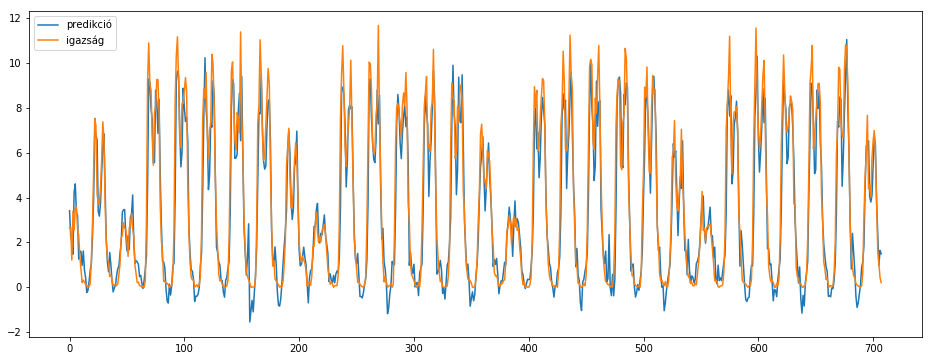

In [249]:
sqid = tstix[20]
subdta = tstprep[tstprep["squareid"]==sqid]
prd = linearmdl.predict(subdta[trfeatures].as_matrix())
truth = subdta[trtarget].as_matrix()
f = plt.figure()
plt.plot(prd, label="predikció")
plt.plot(truth, label="igazság")
plt.legend()
f.set_size_inches(16,6)